# Week 5

In [2]:
# Imports
import pandas as pd
import matplotlib as plt
import numpy as np

# Do not truncate the data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("../Week1/merged_data.csv")
focus_crimes = [
    'WEAPON LAWS', 'PROSTITUTION', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY']
df = df[df['Category'].isin(focus_crimes)]

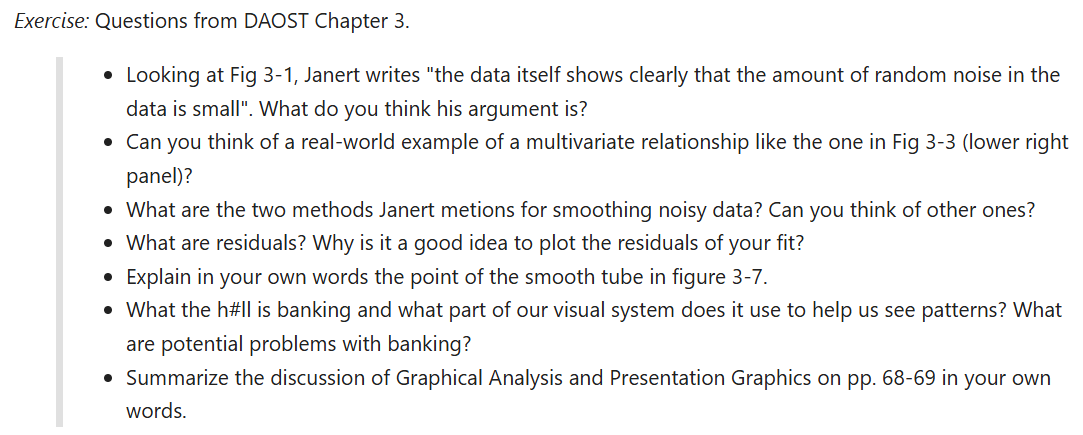

1. Fig 3-1 shows points following a line pattern.
2. Running pace and distance of run of runnners.
3. Weighted splines and LOESS. Another option could be some type of averaging of for example y values in a span of x values.
4. Residuals are the results of subtracting the actual values from the smoothed line. We plot the residuals to check whether the smoothing of the data is accurate. If the the residuals show some other pattern than linear distribution around zero it could mean that the smoothing is inaccurate.
5. The tube gives an indication of where the smoothing may be inaccurate. If the tube is particularly wide at points it means that the smoothing does no represents the data at that point.
6. Banking adjusts the apect ratios of plots to ensure that most slopes are at angle that is easy for humans to recognize. It relies on our affinity for recognizing patterns in certain formats such as slopes of 45 degree angles. Banking may skew the plots to such a degree that its magnitudes become unclear or hard to read.
7. Graphical Analysis deals with discovering something new about your data. This involves exploring the data through various plots and seeing if some new patterns can be discovered. Presentation Graphics, on the other hand, deals with how to best communicate already known findings. Here, the focus in on clear communication, labels etc.

# Exercise 2.2: Logarithms and logarithmic plots.

### First, a couple of questions:

1. What kind of relationships will a semi-log plot help you discover? 

	Exponential growing or decreasing values of one value.

2. What kind of functions will loglog plots help you see?

	Power laws are rendered as straight lines. So data where both axes span many orders of magnitude will be well suited.

### Second, create a version of this plot from Week 1, where you display the y-axis on log-scale. Comment on what the plot looks like. Do any new insights arise?

Text(0, 0.5, 'Number of Occurences')

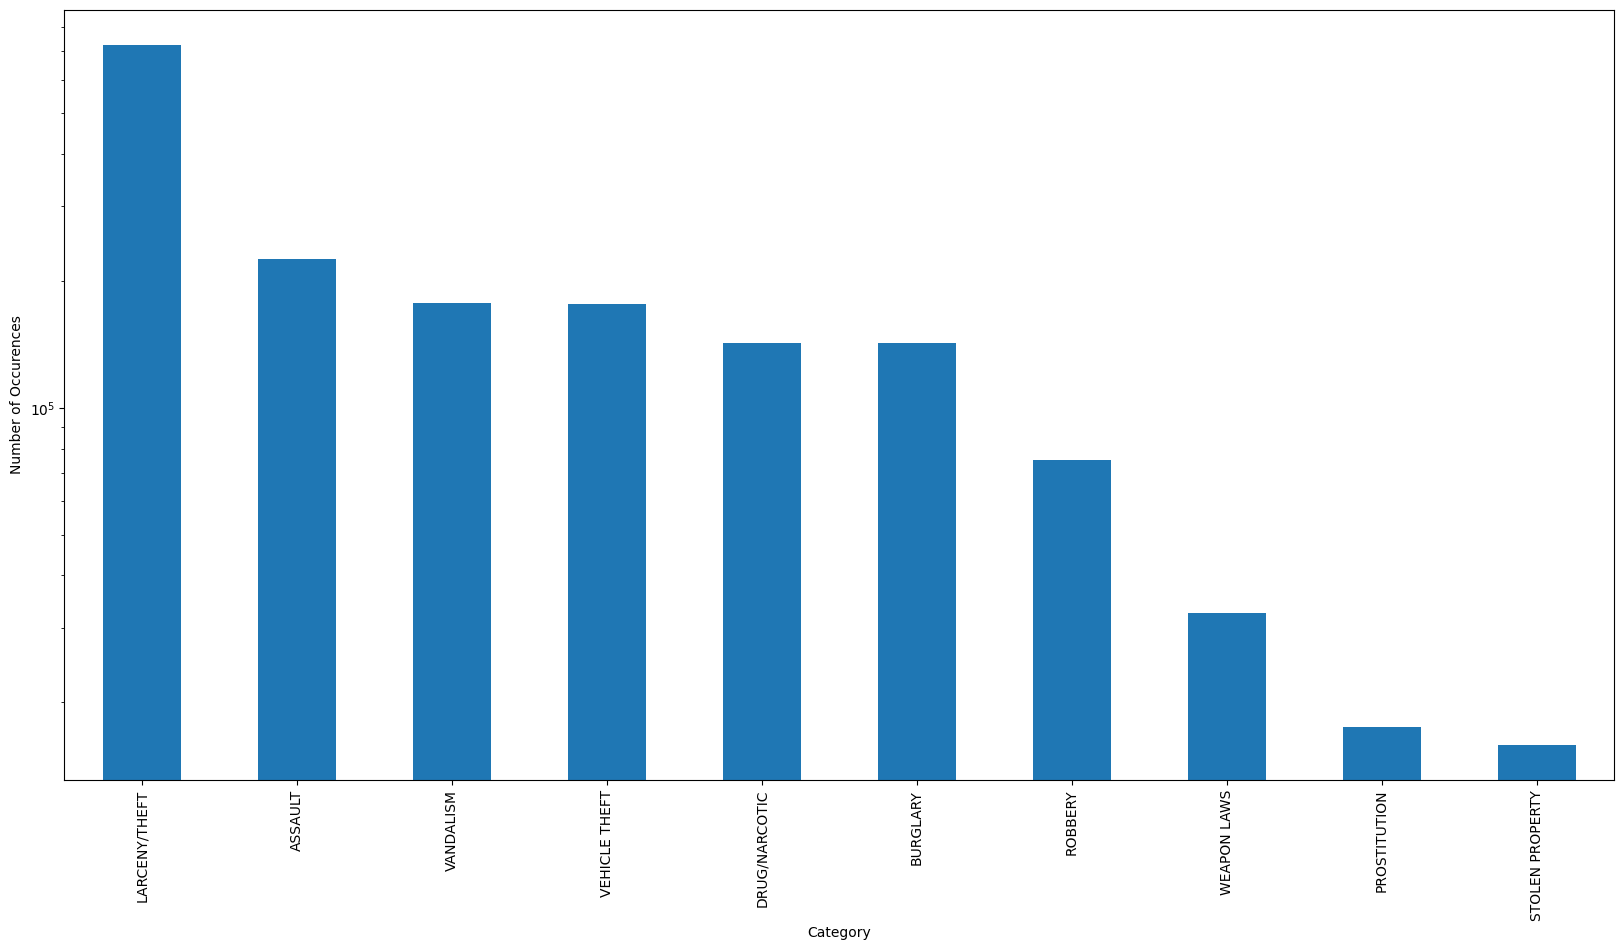

In [4]:
# Bar plot of crime occurences
plot = df['Category'].value_counts().plot(kind='bar', figsize=(20,10))
plot.set_yscale('log')
plot.set_xlabel('Category')
plot.set_ylabel('Number of Occurences')

As the values seem to be somwhat linearily distributed in the log plot the data must be roughly exponentially distributed.

### Third, let's also try a loglog plot. Inspired by this article I would expect that especially theft could be characterized by a power law distribution also in San Francisco.

#### Step 1: Divide San Francisco into a grid roughly 100m x 100m

In [5]:
df_grid = df

# Look at specific crime
df_grid = df_grid[df_grid['Category'] == 'LARCENY/THEFT']

# Remove outliers
df_grid = df_grid[(df_grid.Latitude>37.7) & (df_grid.Latitude<37.82) & (df_grid.Longitude>-122.52) & (df_grid.Longitude<-122.35)]

# Divide SF in 100x100m grid
step = 0.001 # 100m
to_bin = lambda x: np.floor(x / step) * step
df_grid["latBin"] = to_bin(df.Latitude)
df_grid["lonBin"] = to_bin(df.Longitude)
groups = df_grid.groupby(["latBin", "lonBin"])

# Count number of crimes in each grid
df_grid = groups.size().reset_index(name='count')

Text(0, 0.5, 'Number of grids')

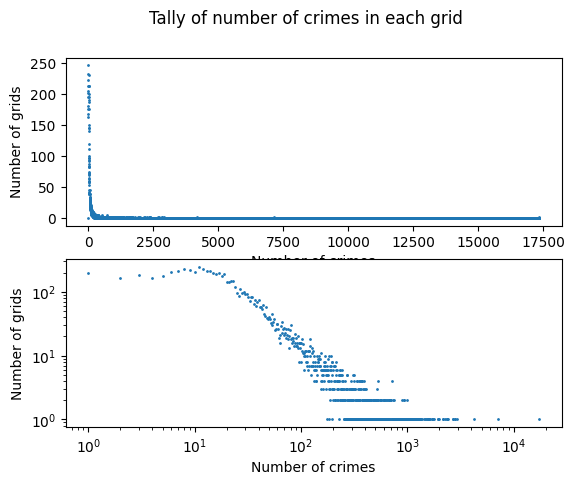

In [6]:
# Find max and min values
max_val = df_grid['count'].max()

# Tally up the number of crimes in each grid
tally = []
for k in range(0, int(max_val)+1):
    tally.append(df_grid[df_grid['count'] == k].shape[0])
    
# Scatter Subplot tally and log-log tally
fig, axs = plt.pyplot.subplots(2)
fig.suptitle('Tally of number of crimes in each grid')
axs[0].scatter(range(0, int(max_val)+1), tally, s=1)
axs[0].set_xlabel('Number of crimes')
axs[0].set_ylabel('Number of grids')
axs[1].scatter(range(0, int(max_val)+1), tally, s=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Number of crimes')
axs[1].set_ylabel('Number of grids')

We see that there is a power-law distribution of theft given the somewhat linear distribution in the log log plot.

# Part 2 Linear Regression
### Which pair of the 10 focus crimes have the the most similar temporal pattern across the week? (And which pair is most dissimilar).

First step is to set up the subplots

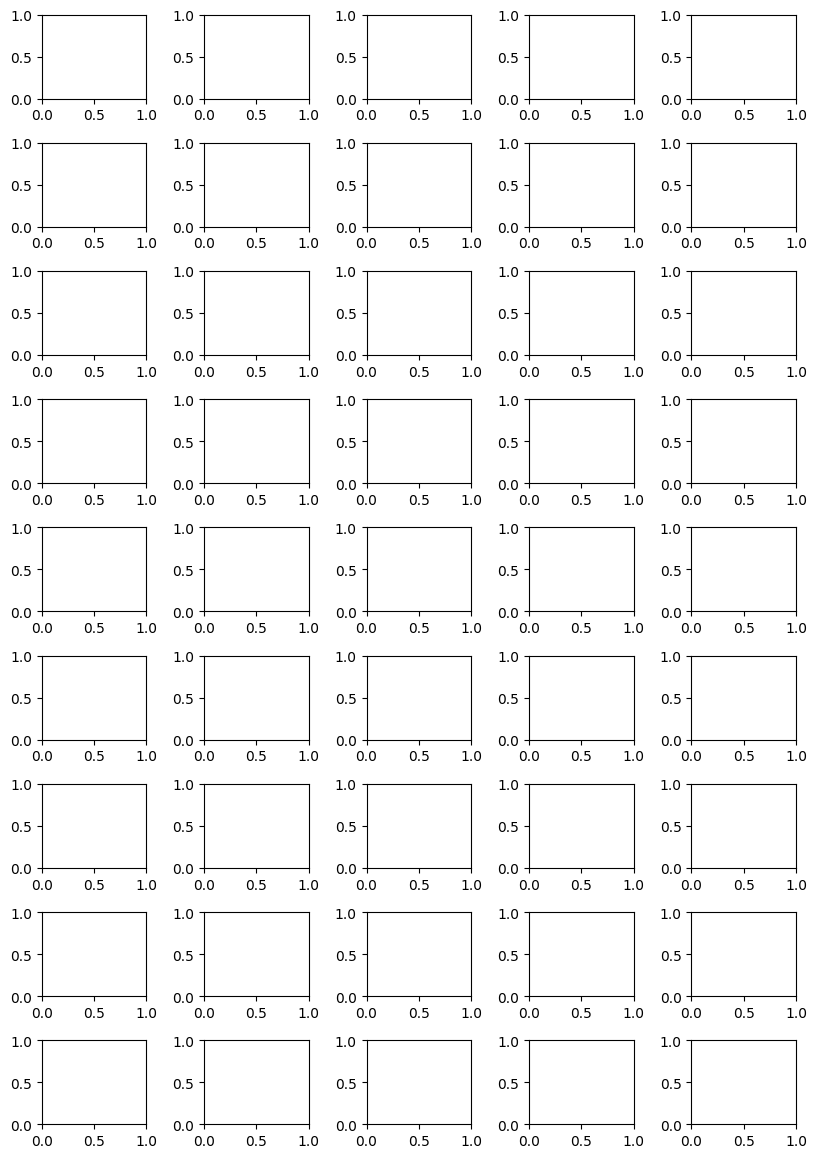

In [7]:
# Create 5 by 9 grid subplot
fig, axs = plt.pyplot.subplots(9, 5)
fig.set_size_inches(8.27,11.69)	# A4 size
fig.tight_layout()

Next up we get the hour of the week

In [8]:
# Copy df
df_linreg = df

# Convert DayOfWeek to integers
df_linreg["DayOfWeek"] = df_linreg["DayOfWeek"].replace({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6})

# Create HourOfWeek
df_linreg["HourOfWeek"] = df_linreg["DayOfWeek"]*24 + df_linreg["TimeOfDay"]
print(df_linreg["HourOfWeek"].min(), df_linreg["HourOfWeek"].max())

0 167


Now we calculate a and b for each plot

In [9]:
df_linreg.head()

,Category,PdDistrict,Longitude,Latitude,TimeOfDay,MinuteOfHour,DayOfWeek,DayOfMonth,Month,Year,HourOfWeek
0,ROBBERY,INGLESIDE,-122.420084,37.708311,17,50,0,22,November,2004,17
1,VEHICLE THEFT,PARK,-120.500000,90.000000,20,0,1,18,October,2005,44
2,VEHICLE THEFT,SOUTHERN,-120.500000,90.000000,2,0,6,15,February,2004,146
3,ASSAULT,SOUTHERN,-122.410541,37.770913,17,0,6,21,November,2010,161
4,ASSAULT,TARAVAL,-122.470366,37.745158,15,50,1,2,April,2013,39


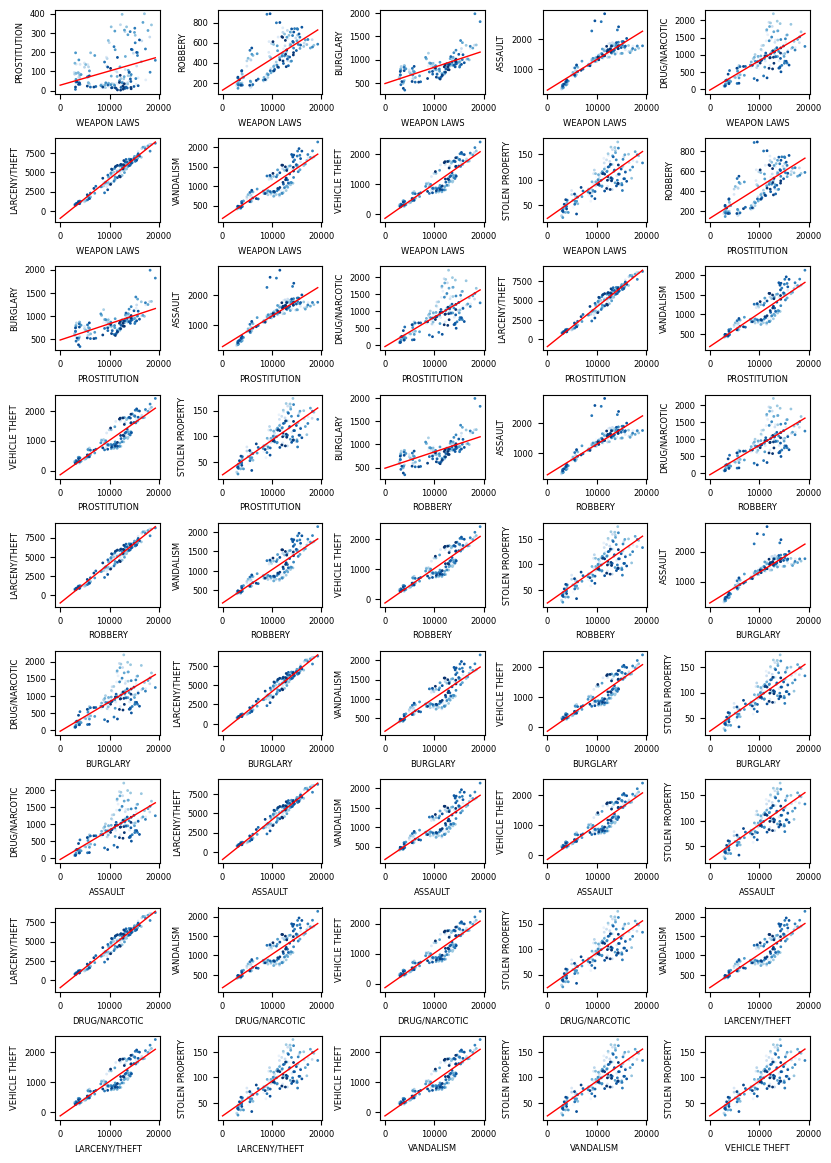

In [10]:
# Create 5 by 9 grid subplot
fig, axs = plt.pyplot.subplots(9, 5)
fig.set_size_inches(8.27,11.69)	# A4 size
fig.tight_layout()

# Plot indices
x_index = 0
y_index = 0

# Iterate over all focus crimes
for i, crime1 in enumerate(focus_crimes):
    # Filter df
	df_crime1 = df_linreg[df_linreg['Category'] == crime1]
	# Group by HourOfWeek
	groups1 = df_linreg.groupby("HourOfWeek")
	
	# Iterate over focus crimes
	for j in range(i+1,len(focus_crimes)):
		crime2 = focus_crimes[j]

		# Filter df
		df_crime2 = df_linreg[df_linreg['Category'] == crime2]
		# Group by HourOfWeek
		groups2 = df_crime2.groupby("HourOfWeek")
  
		# Calculate a and b for linear regression
		x_mean = groups1.size().mean()
		y_mean = groups2.size().mean()
		n = 168
		a = np.sum((groups1.size()-x_mean)*(groups2.size()-y_mean)) / (np.sum((groups1.size()-x_mean)**2))
		# a = (np.sum(groups1.size()*groups2.size()) - (n * x_mean*y_mean)) / (np.sum(groups1.size()**2) - (n * x_mean)**2)
		b = y_mean - a * x_mean		

		# Scatter plot of crime1 and crime2
		# axs[y_index, x_index].scatter(groups1.size(), groups2.size(), s=1)
		# Add gradient color to scatter plot
		axs[y_index, x_index].scatter(groups1.size(), groups2.size(), c=groups1.size().index, cmap='Blues', s=1)
		# Plot linear regression line
		axs[y_index, x_index].plot([0, groups1.size().max()], [b, a*groups1.size().max()+b], color='red', linewidth=1)
		# Set title and labels
		axs[y_index, x_index].set_xlabel(crime1, fontsize=6)
		axs[y_index, x_index].set_ylabel(crime2, fontsize=6)
		axs[y_index, x_index].tick_params(axis='both', which='major', labelsize=6)

		# Increment x index
		x_index += 1
		# Reset x index
		if x_index == 5:
			x_index = 0
			y_index += 1

# Show plots
plt.pyplot.show()